# One Sided Selection Analysis

<blockquote>The procedure first finds the most difficult observations to correctly classify from the majority class. 

The algorithm then proceeds to remove noisy observations utilizing Tomek Links.</blockquote>

## Libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import OneSidedSelection

plt.style.use("dark_background")

---

## Create Data

In [2]:
def make_data(sep):
    
    # Returns arrays
    X, y = make_classification(
        n_samples= 1000,
        n_features = 2,
        n_redundant=0,
        n_clusters_per_class = 1,
        weights= [0.99],
        class_sep= sep,
        random_state = 10
    )
    
    # Transform arrays into pandas dataframe and series
    X = pd.DataFrame(X, columns = ["varA", "varB"])
    y = pd.Series(y)

    return X, y

0    985
1     15
Name: count, dtype: int64


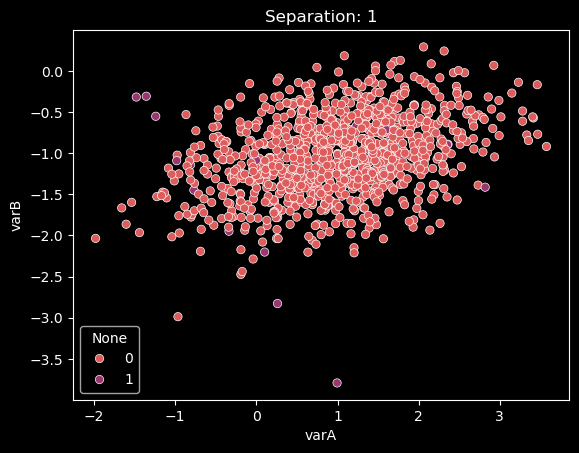

0    985
1     15
Name: count, dtype: int64


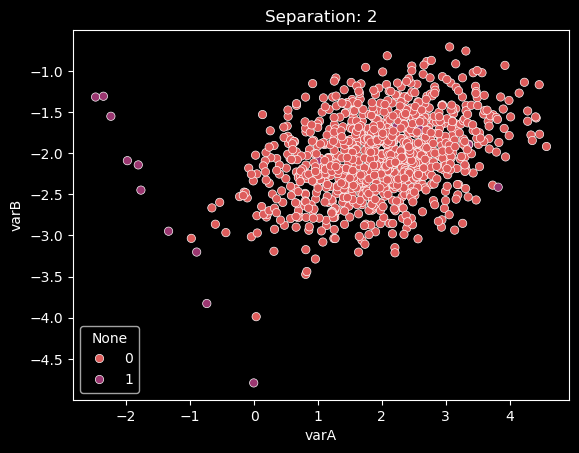

0    985
1     15
Name: count, dtype: int64


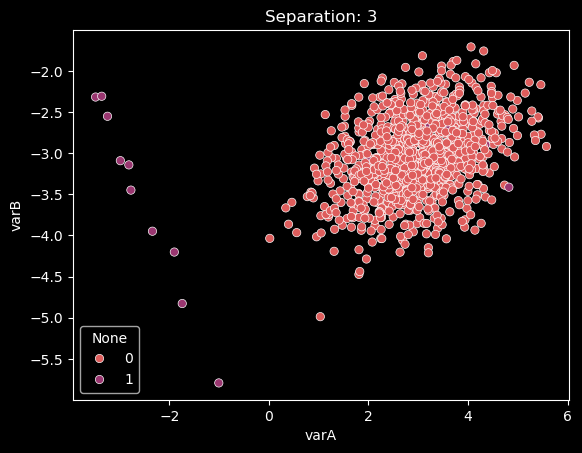

In [9]:
# create datasets with different class separatedness and plot

for sep in range(1,4):
    X, y = make_data(sep)
    
    print(y.value_counts())
    
    sns.scatterplot(
        data= X, 
        x = "varA",
        y = "varB",
        hue = y,
        palette= "flare"
    )
    plt.title("Separation: {}".format(sep))
    plt.show();

In [5]:
X, y = make_data(sep = 1)

oss = OneSidedSelection(
    sampling_strategy= "auto",
    random_state= 42,
    n_neighbors = 1,
)

X_resampled, y_resampled = oss.fit_resample(X, y)

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X_resampled.shape, y_resampled.shape

((825, 2), (825,))

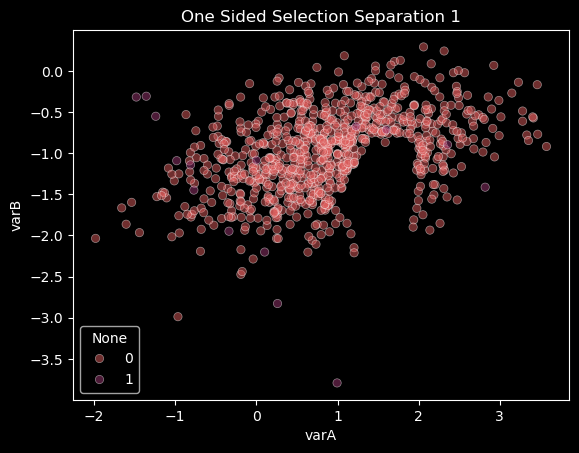

(825, 2) (825,)


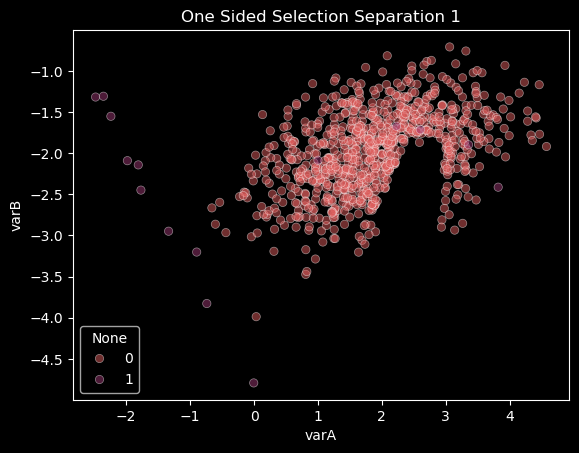

(822, 2) (822,)


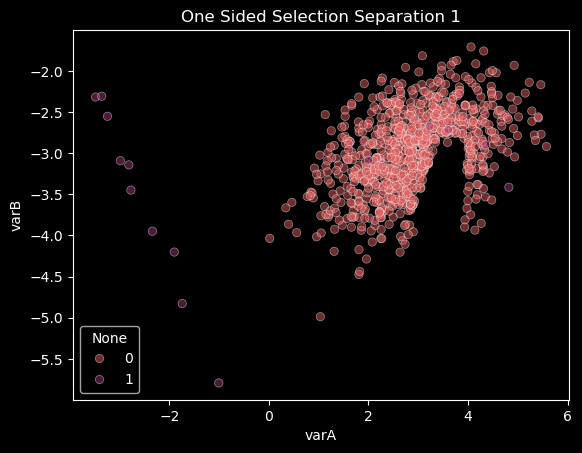

(823, 2) (823,)


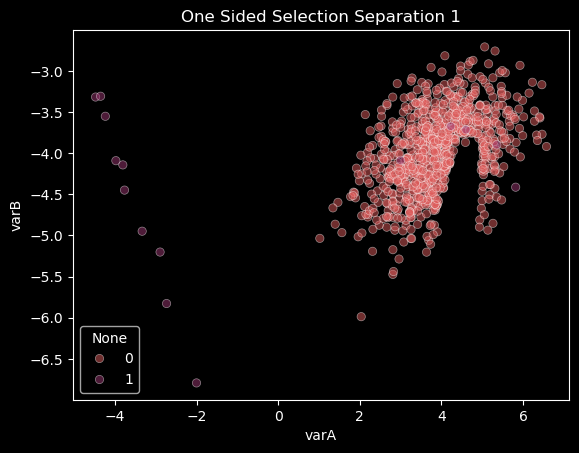

(823, 2) (823,)


In [28]:
# Plot resampled dataset with varying separation

for sep in range(1, 5):
    X, y = make_data(sep = sep)
    
    oss = OneSidedSelection(
        sampling_strategy= "auto",
        random_state= 42,
        n_neighbors= 1,
        n_jobs = 6
    )
    
    X_resampled, y_resampled = oss.fit_resample(X, y)
    
    sns.scatterplot(
        data = X_resampled,
        x = "varA",
        y = "varB",
        hue = y_resampled,
        palette= "flare",
        alpha = 0.5
    )

    plt.title("One Sided Selection Separation 1")
    plt.show()
    
    print(X_resampled.shape, y_resampled.shape)

---

## Performance Comparison

In [18]:
data = pd.read_csv("../kdd2004.csv").sample(10000, random_state= 42)

data["target"] =  data["target"].map({-1:0, 1:1})

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
136838,25.35,38.89,-0.87,-11.0,49.0,1146.4,1.27,-0.64,4.0,-50.5,...,1910.2,-1.34,0.85,2.0,-38.0,110.6,0.76,0.68,0.08,0
8864,16.98,36.67,-0.83,-23.5,24.5,1233.5,0.20,0.50,-7.0,-62.5,...,899.7,1.24,1.67,11.0,-48.0,437.6,-0.08,0.38,0.22,0
12804,62.84,27.74,0.82,17.5,34.0,2619.6,-0.53,-0.60,-12.5,-74.5,...,3004.7,0.24,-0.48,2.0,-57.0,94.0,2.18,0.27,-0.33,0
42340,54.07,27.07,-0.34,-35.5,-2.5,1702.8,0.02,0.53,-16.0,-83.0,...,1511.8,0.27,0.66,-2.0,-84.0,1257.1,-1.23,0.26,-0.26,0
25794,70.54,30.86,0.90,-9.0,12.5,1072.6,0.49,0.83,5.5,-66.5,...,1130.2,1.94,-1.30,-9.0,-29.0,96.2,1.94,-0.04,-0.09,0


In [19]:
# Imbalanced Data

data["target"].value_counts(normalize= True)

target
0    0.9931
1    0.0069
Name: proportion, dtype: float64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels = ["target"], axis = 1),
    data["target"],
    test_size= 0.3,
    random_state = 0
)

X_train.shape, y_train.shape


((7000, 74), (7000,))

In [21]:
# Apply under-sampling to training set

oss = OneSidedSelection(
    sampling_strategy= "auto",
    n_neighbors= 1,
    n_jobs= 6,
    random_state= 42
)

X_train_resampled, y_train_resampled = oss.fit_resample(X_train, y_train)

In [22]:
# Size of training set

X_train_resampled.shape, y_train_resampled.shape

((6926, 74), (6926,))

In [23]:
y_train_resampled.value_counts()

target
0    6883
1      43
Name: count, dtype: int64

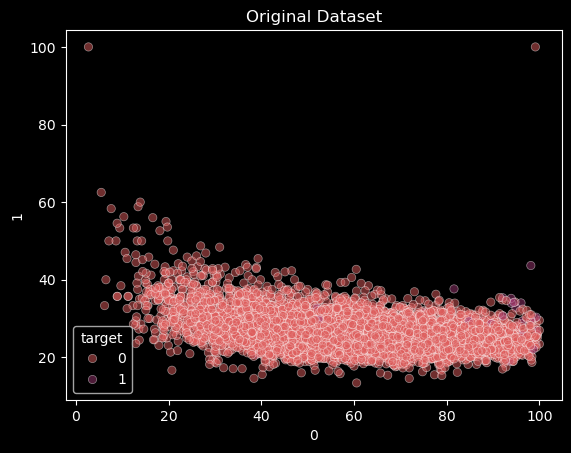

In [27]:
# Plot original dataset

sns.scatterplot(
    data = X_train,
    x = "0",
    y = "1",
    hue = y_train,
    palette= "flare",
    alpha = 0.5
)
plt.title("Original Dataset")
plt.show()


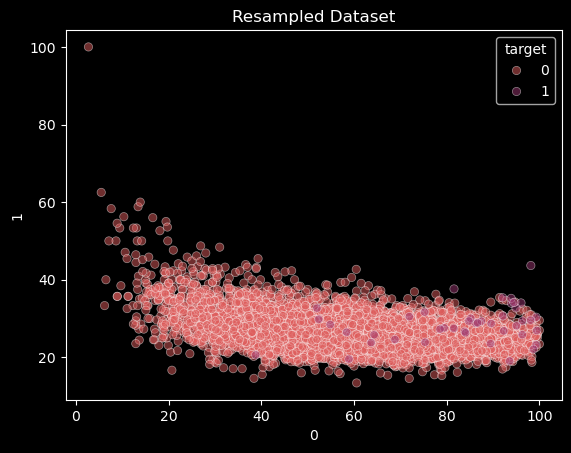

In [26]:
# Plot resampled data

sns.scatterplot(
    data = X_train_resampled,
    x = "0",
    y = "1",
    hue = y_train_resampled,
    palette= "flare",
    alpha = 0.5
)

plt.title("Resampled Dataset")
plt.show()

<blockquote>Minority class observations are visible within the cloud of observations from the majority class.<blockquote>

## Model Comparison

In [29]:
def run_randomforests(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(
        n_estimators= 100,
        random_state= 42,
        max_depth= 4
    )
    
    rf.fit(X_train, y_train)
    
    print("Train set")
    pred = rf.predict_proba(X_train)
    
    print("Random Forests roc-auc: {}".format(roc_auc_score(y_train, pred[:,1])))
    
    print("Test set")
    pred = rf.predict_proba(X_test)
    print("Random Forests roc-auc: {}".format(roc_auc_score(y_test, pred[:, 1])))

In [31]:
# evaluate performance of the algorithm built 
# using the imbalanced dataset

run_randomforests(X_train,
                  y_train,
                  X_test,
                  y_test)

Train set
Random Forests roc-auc: 0.9985258280935045
Test set
Random Forests roc-auc: 0.9822564792302519


In [33]:
# Evaluate performance of the algorithm built using 
# under-sampled dataset

run_randomforests(
    X_train_resampled,
    y_train_resampled,
    X_test,
    y_test
)

Train set
Random Forests roc-auc: 0.9961854113099682
Test set
Random Forests roc-auc: 0.9639762557550049


<blockquote>One side Selection did not seem to improve the performance.<blockquote>

---